# Importações

In [25]:
#!pip install scikit-learn pandas numpy matplotlib xgboost smogn imbalanced-learn scipy

#Caso dê algum erro nas importacoes rodar os comandos abaixo:
#!pip uninstall -y scikit-learn imbalanced-learn scipy
#!pip install scikit-learn==1.3.2 scipy==1.11.4 imbalanced-learn==0.11.0

In [26]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt

# Pré-processamento e pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Modelos de ML
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Validação e busca de hiperparâmetros
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform
from scipy.stats.mstats import winsorize

# Métricas
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# SMOGN, SMOTE e SMOTEENN
import smogn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# Carregando dataset

In [27]:
df = pd.read_csv('filmes_luan.csv')

# Identificando e tratando outliers em variáveis numéricas do df

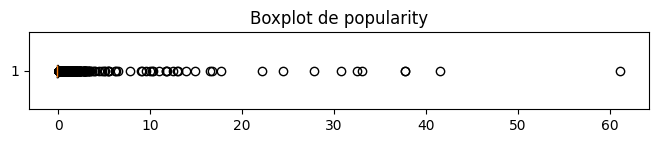

In [28]:
numeric_cols = df[['popularity']].columns

for col in numeric_cols:
    plt.figure(figsize=(8, 1))
    plt.boxplot(df[col], vert=False)
    plt.title(f'Boxplot de {col}')
    plt.show()

### Tratamento com Winsorization + LOG nos outliers
 - Substitui outliers extremos pelos percentis limite.
 - reduz o impacto de valores extremos sem truncar bruscamente como o CAP faz.
 - reduzindo o impacto desses valores sem removê-los do dataset.

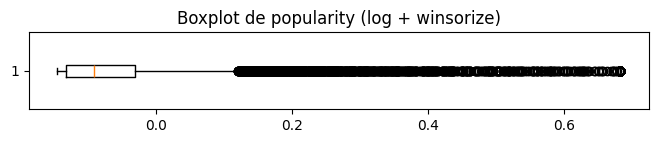

In [29]:
df['popularity'] = np.log1p(df['popularity'])
df['popularity'] = winsorize(df['popularity'], limits=[0.01, 0.01])

plt.figure(figsize=(8, 1))
plt.boxplot(df['popularity'], vert=False)
plt.title('Boxplot de popularity (log + winsorize)')
plt.show()

# Treinamento
- Modelo XGBRegressor
- Modelo SVM

### Definindo as colunas de features e o target

In [30]:
X = df.drop(columns=['vote_average'])
y = df['vote_average']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=87)

categorical_col = ['original_language']
numerical_cols = [col for col in X_train.columns if col not in categorical_col]

In [31]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat_train = ohe.fit_transform(X_train[categorical_col])
X_cat_test = ohe.transform(X_test[categorical_col])

scaler = StandardScaler()
X_num_train = scaler.fit_transform(X_train[numerical_cols])
X_num_test = scaler.transform(X_test[numerical_cols])

X_train_transf = np.concatenate([X_cat_train, X_num_train], axis=1)
X_test_transf = np.concatenate([X_cat_test, X_num_test], axis=1)

# Aplicando SMOGN, SMOTE e SMOTEENN

In [32]:
# Transformando o alvo contínuo em 5 bins para usar SMOTE e SMOTEENN (Necessário pois SMOTE e SMOTEENN não foi feito para regressão)
y_train_binned = pd.qcut(y_train, q=5, labels=False)

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_transf, y_train_binned)

smoteenn = SMOTEENN(random_state=42)
X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train_transf, y_train_binned)

In [33]:
#Aplicando SMOGN (oversampling para regressão)
X_smogn_df = pd.DataFrame(X_train_transf)
X_smogn_df['vote_average'] = y_train.values

X_smogn = smogn.smoter(
    data=X_smogn_df,
    y='vote_average',
    k=3,
    samp_method='balance'
)
y_smogn = X_smogn['vote_average']
X_smogn = X_smogn.drop(columns=['vote_average'])

r_index: 100%|##########| 60/60 [00:00<00:00, 270.10it/s]


# Pipeline com XGBoost (RandomSearch)

In [34]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_col),
    ('num', StandardScaler(), numerical_cols)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

param_dist = {
    'regressor__n_estimators': randint(100, 300),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.3),
    'regressor__subsample': uniform(0.7, 0.3),
    'regressor__colsample_bytree': uniform(0.7, 0.3),
}

kf = KFold(n_splits=5, shuffle=True, random_state=87)

xgb_rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=60,
    cv=kf,
    scoring='r2',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

xgb_rand.fit(X_train, y_train)
print("Melhores parâmetros:", xgb_rand.best_params_)
print("Melhor R² (validação cruzada):", xgb_rand.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Melhores parâmetros: {'regressor__colsample_bytree': 0.7917342580817835, 'regressor__learning_rate': 0.11623601677251061, 'regressor__max_depth': 4, 'regressor__n_estimators': 124, 'regressor__subsample': 0.8149796080497678}
Melhor R² (validação cruzada): 0.40386714905260906


# Pipeline com SVR (RandomSearch)

In [35]:
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', SVR())
])

param_dist = {
    'regressor__kernel': ['rbf', 'linear'],
    'regressor__C': loguniform(1e-2, 1e2),
    'regressor__epsilon': uniform(0.01, 0.3),
    'regressor__gamma': ['scale', 'auto']
}

svm_rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=kf,
    scoring='r2',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

svm_rand.fit(X_train, y_train)
print("Melhores parâmetros:", svm_rand.best_params_)
print("Melhor R² (validação cruzada):", svm_rand.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores parâmetros: {'regressor__C': 2.481040974867813, 'regressor__epsilon': 0.05680559213273095, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}
Melhor R² (validação cruzada): 0.2583237814918549


# Avaliação dos modelos

In [36]:
modelos_bal = {
    'XGBRegressor + SMOTE': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    'XGBRegressor + SMOTEENN': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    'XGBRegressor + SMOGN': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    'SVR + SMOTE': SVR(C=1.0, epsilon=0.1, kernel='rbf'),
    'SVR + SMOTEENN': SVR(C=1.0, epsilon=0.1, kernel='rbf'),
    'SVR + SMOGN': SVR(C=1.0, epsilon=0.1, kernel='rbf'),
}

resultados = []

for nome, modelo in modelos_bal.items():
    if 'SMOGN' in nome:
        X_bal, y_bal = X_smogn, y_smogn
    elif 'SMOTEENN' in nome:
        X_bal, y_bal = X_smoteenn, y_smoteenn
    else:
        X_bal, y_bal = X_smote, y_smote

    modelo.fit(X_bal, y_bal)
    y_pred = modelo.predict(X_test_transf)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    resultados.append({'Modelo': nome, 'MSE': mse, 'RMSE': rmse, 'R²': r2})

resultados_df = pd.DataFrame(resultados)
print(resultados_df.sort_values(by='R²', ascending=False))

                    Modelo        MSE      RMSE        R²
2     XGBRegressor + SMOGN   3.096916  1.759806  0.332176
5              SVR + SMOGN   3.778919  1.943944  0.185108
0     XGBRegressor + SMOTE  16.565900  4.070123 -2.572295
3              SVR + SMOTE  17.371902  4.167961 -2.746103
1  XGBRegressor + SMOTEENN  17.950679  4.236824 -2.870911
4           SVR + SMOTEENN  18.232393  4.269941 -2.931660
